In [1]:
#using MLJ
#using StatsBase
using Random
#using PyPlot
using CategoricalArrays
using PrettyPrinting
import DataFrames
#using LossFunctions
using LinearAlgebra
using Plots

In [2]:
function generate_customers(
        rng::Random.MersenneTwister, 
        n_segments::Int, 
        n_samples::Int, 
        n_dim::Int; 
        noise_ratio::Float64=0.2)
    center = randn(rng, Float64, (n_segments, n_dim))
    assignment = rand(rng, 1:n_segments, n_samples)
    assigned_center = center[assignment, :]
    (center=center, assignment=assignment, context=randn(rng, Float64, (n_samples, n_dim)) * noise_ratio + assigned_center)
end

function generate_outcome(
        rng::Random.MersenneTwister, 
        context::Matrix{Float64}, 
        action_centers::Matrix{Float64}, 
        p_max::Float64=0.01, 
        discrimination::Float64=0.1)
    p = exp.(- norm.(eachrow(context - action_centers), 1) .* discrimination) .* p_max
    (outcome=convert.(Bool, rand(rng, Float64, size(p)) .<= p), proba=p)
end

generate_outcome (generic function with 3 methods)

In [3]:
n_segments = 10;
n_step_size = 1000;
n_dim = 2;
n_samples = 5000;
p_max = 0.5;
discrimination = 2.0;

In [4]:
center, assignment, context = generate_customers(MersenneTwister(1234), n_segments, n_samples, n_dim);
best_outcome, best_proba = generate_outcome(MersenneTwister(1234), context, center[assignment, :], p_max, discrimination);

action = rand(MersenneTwister(1234), 1:n_segments, n_samples);
outcome, proba = generate_outcome(MersenneTwister(1234), context, center[action, :], p_max, discrimination);

In [ ]:
Plots.PyPlotBackend()

In [ ]:
scatter(context[:, 1], context[:, 2], markersize=2, 
    zcolor = best_proba, 
    m = (:heat, 0.8, Plots.stroke(0.1, :green)), 
    lab = "grad")
scatter!(center[:, 1], center[:, 2], markersize=4)

In [5]:
# generate features with context x all possible actions to choose from the best action
all_context = repeat(context, n_segments);
all_actions = repeat(1:n_segments, inner=n_samples);
all_features = hcat(all_context, all_actions);
all_outcome, all_proba = generate_outcome(MersenneTwister(1234), all_context, center[all_actions, :], p_max, discrimination);

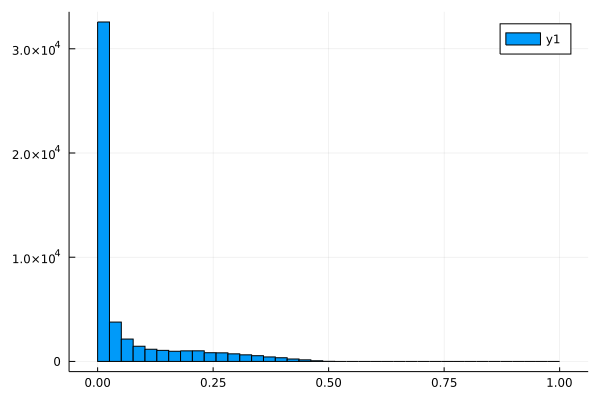

In [6]:
histogram(all_proba, bins=range(0.0, stop=1.0, length=40))

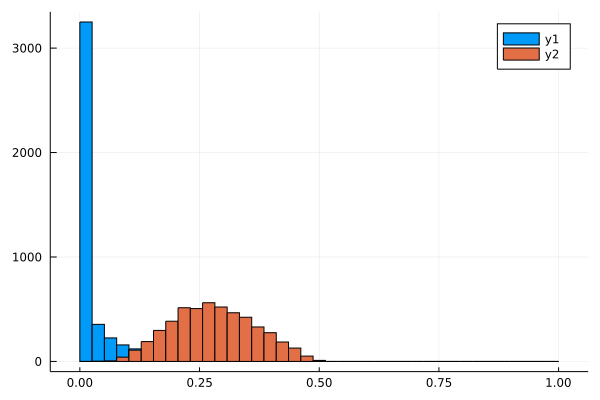

In [7]:
histogram(proba, bins=range(0.0, stop=1.0, length=40))
histogram!(best_proba, bins=range(0.0, stop=1.0, length=40))

In [8]:
using MLJ
#import Pkg; Pkg.add("MLJDecisionTreeInterface")
#import Pkg; Pkg.add("MLJScikitLearnInterface")

In [9]:
RF = @load RandomForestClassifier pkg=ScikitLearn

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/lingyi/.julia/packages/MLJModels/SlRVK/src/loading.jl:168


import MLJScikitLearnInterface ✔


MLJScikitLearnInterface.RandomForestClassifier

In [10]:
Tree_DT = @load DecisionTreeClassifier pkg=DecisionTree

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/lingyi/.julia/packages/MLJModels/SlRVK/src/loading.jl:168


MLJDecisionTreeInterface.DecisionTreeClassifier

In [11]:
rf = RF(n_estimators=300, n_jobs=-1)

RandomForestClassifier(
    n_estimators = 300,
    criterion = "gini",
    max_depth = nothing,
    min_samples_split = 2,
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0,
    max_features = "auto",
    max_leaf_nodes = nothing,
    min_impurity_decrease = 0.0,
    bootstrap = true,
    oob_score = false,
    n_jobs = -1,
    random_state = nothing,
    verbose = 0,
    warm_start = false,
    class_weight = nothing,
    ccp_alpha = 0.0,
    max_samples = nothing) @466

In [12]:
tree = Tree_DT(min_samples_leaf=20)

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 20,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5) @742

In [13]:
feature = DataFrames.DataFrame(hcat(context, action));
outcome = CategoricalArray(outcome);

best_feature = DataFrames.DataFrame(hcat(context, assignment));
best_outcome = CategoricalArray(best_outcome);

In [14]:
mtree = machine(tree, feature, outcome);
mrf = machine(rf, feature, outcome);

In [15]:
train, test = partition(eachindex(outcome), 0.7, shuffle=true, rng=MersenneTwister(1234)); # 70:30 split

In [28]:
@time fit!(mtree, rows=train)

  0.004962 seconds (1.10 k allocations: 553.719 KiB)


┌ Info: Training Machine{DecisionTreeClassifier,…} @672.
└ @ MLJBase /Users/lingyi/.julia/packages/MLJBase/pCCd7/src/machines.jl:342


Machine{DecisionTreeClassifier,…} @672 trained 8 times; caches data
  args: 
    1:	Source @161 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @833 ⏎ `AbstractVector{Multiclass{2}}`


In [38]:
@time fit!(mrf, rows=train)

┌ Info: Training Machine{RandomForestClassifier,…} @759.
└ @ MLJBase /Users/lingyi/.julia/packages/MLJBase/pCCd7/src/machines.jl:342


  0.414193 seconds (451 allocations: 326.844 KiB)


Machine{RandomForestClassifier,…} @759 trained 15 times; caches data
  args: 
    1:	Source @834 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @453 ⏎ `AbstractVector{Multiclass{2}}`


In [39]:
@time mtree_auc = evaluate!(mtree, rows=test, measure=area_under_curve);

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /Users/lingyi/.julia/packages/MLJBase/pCCd7/src/resampling.jl:343
Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


  0.016302 seconds (17.42 k allocations: 3.021 MiB)


In [40]:
mtree_auc.measurement

1-element Vector{Float64}:
 0.6559553506826377

In [41]:
@time mrf_auc = evaluate!(mrf, rows=test, measure=area_under_curve);

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /Users/lingyi/.julia/packages/MLJBase/pCCd7/src/resampling.jl:343
Evaluating over 6 folds: 100%[=========================] Time: 0:00:02


  2.365523 seconds (10.20 k allocations: 1.626 MiB)


In [42]:
mrf_auc.measurement

1-element Vector{Float64}:
 0.7218471877847557

In [43]:
for model in (mtree, mrf)
    all_pred = predict(model, all_features);
    all_pred_proba = reshape(all_pred.prob_given_ref[2], n_samples, n_segments);
    mxval, mxidx = findmax(all_pred_proba; dims=2);
    pred_actions = convert(Array{Int}, broadcast(x->x[2], mxidx))[:, 1];
    pred_outcome, pred_proba = generate_outcome(MersenneTwister(1234), context, center[pred_actions, :], p_max, discrimination);
    regrets = sum(best_proba - pred_proba)
    success_rate = sum(pred_actions .== assignment)/n_samples
    println(regrets)
    println(success_rate)
end

529.4626371877224
0.3574
440.2547292737524
0.447


In [ ]:
idx_shuffled = randperm(MersenneTwister(1234), n_samples);
pos_split = convert(Int, floor(n_samples * 0.75));
idx_train = idx_shuffled[1:pos_split];
idx_test = idx_shuffled[(pos_split+1):n_samples];

feature = hcat(context, action);
trainX = feature[idx_train, :];
trainy = outcome[idx_train];

testX = feature[idx_test, :];
testy = outcome[idx_test];

In [ ]:
tree = Tree()

In [ ]:
trainX = DataFrames.DataFrame(trainX);
trainy = CategoricalArray(trainy);
testX = DataFrames.DataFrame(testX);
testy = CategoricalArray(testy);

In [ ]:
mach = machine(tree, trainX, trainy)

In [ ]:
fit!(mach, rows = train)

In [ ]:
yhat = MLJ.predict_mode(mach, trainX[test,:]);

In [ ]:
accuracy(yhat, trainy[test])

In [ ]:
xgb  = MLJXGBoostInterface.XGBoostClassifier()
xgbm = machine(xgb, trainX, trainy)

In [ ]:
r = range(xgb, :num_round, lower=50, upper=900)
curve = learning_curve!(xgbm, range=r, resolution=50,
                        measure=HingeLoss())

In [ ]:
figure(figsize=(8,6))
plot(curve.parameter_values, curve.measurements)
xlabel("Number of rounds", fontsize=14)
ylabel("HingeLoss", fontsize=14)
xticks([10, 100, 200, 500], fontsize=12)

In [ ]:
MLJ.predict(mtm,)

In [ ]:
scatter(context[:, 1], context[:, 2], title = "My Scatter Plot", markersize=1, )

In [ ]:
typeof(context)

In [ ]:
outcome, proba = generate_outcome(
    MersenneTwister(1234), 
    context, 
    center[assignment, :], 
    0.8, 2.0);

In [ ]:
histogram(proba)